In [16]:
import os
import numpy as np
import statistics
import math

import pandas as pd
import matplotlib.pyplot as plt

In [17]:
data_folder = '/Users/rebekahzhang/Documents/shuler_lab/behavior_data'
file_name = 'data_RZ011_2023-03-02_16-04-47.txt'
path = os.path.join(data_folder, file_name)
print(path)
session = pd.read_csv(path, skiprows=3)
session.head()

/Users/rebekahzhang/Documents/shuler_lab/behavior_data/data_RZ011_2023-03-02_16-04-47.txt


,session_time,block_num,session_trial_num,block_trial_num,state,time_bg,reward_size,value,key
0,1.677791e+09,-1,-1,-1,in_background,None,NaN,1,session
1,1.677791e+09,0,-1,-1,in_background,3.021666666666667,NaN,1,block
2,1.677791e+09,0,0,0,in_background,3.021666666666667,NaN,1,trial
3,1.677791e+09,0,0,0,in_background,3.021666666666667,NaN,1,background
4,1.677791e+09,0,0,0,in_background,3.021666666666667,NaN,1,lick


## session analysis

In [18]:
# basic session result
total_blocks = session.block_num.max()
total_trials = session.session_trial_num.max()
total_reward = session.reward_size.sum()
total_time = session.session_time.max() - session.session_time.min()
total_blcok_list = range(total_blocks + 1)
total_trial_list = range(total_trials + 1)

In [19]:
# get the shortest lick, longest lick, median lick, mean, standard deviation
lick_start = session.loc[(session['key'] == 'lick') & (session['value'] == 1)]
lick_start_times = lick_start['session_time'].tolist()
lick_end = session.loc[(session['key'] == 'lick') & (session['value'] == 0)]
lick_end_times = lick_end['session_time'].tolist()
lick_times = [end - start for end, start in zip(lick_end_times, lick_start_times)]
lick_time_min = min(lick_times)
lick_time_max = max(lick_times)
lick_time_med = statistics.median(lick_times)
lick_time_avg = statistics.mean(lick_times)
lick_time_std = statistics.stdev(lick_times)

## trial analysis

In [20]:
# per trial's: block number, block bg time avg, start time, end time
trial_block_nums = []
trial_blk_bg_avgs = []
trial_start_times = []
trial_end_times = []

for i in total_trial_list:
    trial = session.loc[session['session_trial_num'] == i]
    block_num = trial.loc[(trial['key'] == 'trial') & (trial['value'] == 1), 'block_num'].iloc[0]
    blk_bg_avg = trial.loc[(trial['key'] == 'trial') & (trial['value'] == 1), 'time_bg'].iloc[0]
    start_time = trial.loc[(trial['key'] == 'trial') & (trial['value'] == 1), 'session_time'].iloc[0]
    end_time = trial.loc[(trial['key'] == 'trial') & (trial['value'] == 0), 'session_time'].iloc[0]
    
    trial_block_nums.append(block_num)
    trial_blk_bg_avgs.append(blk_bg_avg)
    trial_start_times.append(start_time)
    trial_end_times.append(end_time)

In [21]:
# number of licks during bg per trial
trial_bg_repeats = []
for i in total_trial_list:
    trial = session.loc[session['session_trial_num'] == i]
    bg_repeat = trial['key'].value_counts()['background']
    trial_bg_repeats.append(bg_repeat)

In [22]:
# total time in bg per trial
trial_bg_lengths = []
for i in total_trial_list:
    trial = session.loc[session['session_trial_num'] == i]
    bg_start_idx = trial.index[(trial['key'] == 'trial') & (trial['value'] == 1)].tolist()
    bg_end_idx = trial.index[(trial['key'] == 'wait') & (trial['value'] == 1)].tolist()
    trial_bg = trial.loc[bg_start_idx[0] : bg_end_idx[0]]
    trial_bg_length = trial_bg.session_time.max() - trial_bg.session_time.min()
    trial_bg_lengths.append(trial_bg_length)

In [23]:
# miss trial or not per trial
# if not miss trial, reward per trial, time waited per trial
trial_miss_booleans = []
trial_rewards = []
trial_times_waited = []
for i in total_trial_list:
    trial = session.loc[session['session_trial_num'] == i]
    wait_start_time = trial.loc[(trial['key'] == 'wait') & (trial['value'] == 1), 'session_time'].iloc[0]
    if 'in_consumption' in trial.state.unique() :
        miss_boolean = False
        reward = trial.loc[trial['key'] == 'reward', 'reward_size'].iloc[0]
        consumption_start_time = trial.loc[trial['state'] == 'in_consumption', 'session_time'].iloc[0]
        time_waited = consumption_start_time - wait_start_time
    else :
        miss_boolean = True
        reward = math.nan
        time_waited = math.nan
    trial_rewards.append(reward)
    trial_miss_booleans.append(miss_boolean)
    trial_times_waited.append(time_waited)

In [24]:
# number of consumption licks per trial
trial_consumption_licks = []
for i in total_trial_list:
    trial = session.loc[session['session_trial_num'] == i]
    consumption = trial.loc[trial['state'] == 'in_consumption']
    licks = len(consumption.loc[(consumption['key'] == 'lick') & (trial['value'] == 1)])
    trial_consumption_licks.append(licks)

In [25]:
# all trials
all_trials = pd.DataFrame({'trial_num': total_trial_list, 
                                 'block_num': trial_block_nums,
                                 'start_time': trial_start_times,
                                 'end_time':trial_end_times,
                                 'bg_repeats': trial_bg_repeats, 
                                 'blk_bg_avg': trial_blk_bg_avgs, 
                                 'bg_length': trial_bg_lengths, 
                                 'reward_size': trial_rewards, 
                                 'miss_trial': trial_miss_booleans,  
                                 'time_waited': trial_times_waited, 
                                 'num_consumption_lick': trial_consumption_licks})

In [26]:
# trials that are not miss trials
engaged_trials = all_trials.loc[all_trials['miss_trial'] == False]

In [27]:
# trials that are not miss trials and with no bg repeats
good_trials = engaged_trials.loc[engaged_trials['bg_repeats'] == 1]

In [45]:
good_trials

,trial_num,block_num,start_time,end_time,bg_repeats,blk_bg_avg,bg_length,reward_size,miss_trial,time_waited,num_consumption_lick
4,4,0,1.677791e+09,1.677791e+09,1,3.021666666666667,2.600864,7.085010,False,7.497190,9
9,9,0,1.677791e+09,1.677791e+09,1,3.021666666666667,2.700680,5.077609,False,3.660753,6
53,53,0,1.677792e+09,1.677792e+09,1,3.021666666666667,3.300713,1.499386,False,0.812625,6
60,60,1,1.677793e+09,1.677793e+09,1,1.0098360655737706,0.900702,1.166694,False,0.620129,4
61,61,1,1.677793e+09,1.677793e+09,1,1.0098360655737706,1.100710,1.714117,False,0.941128,3
...,...,...,...,...,...,...,...,...,...,...,...
235,235,3,1.677794e+09,1.677794e+09,1,1.034920634920635,1.000735,7.337715,False,9.281822,1
236,236,3,1.677794e+09,1.677794e+09,1,1.034920634920635,0.900769,1.633209,False,0.892292,2
239,239,3,1.677794e+09,1.677794e+09,1,1.034920634920635,0.900680,7.307233,False,8.872789,2
240,240,3,1.677794e+09,1.677794e+09,1,1.034920634920635,1.100744,6.655814,False,6.163715,1


In [48]:
good_trials.columns.values.tolist()

['trial_num',
 'block_num',
 'start_time',
 'end_time',
 'bg_repeats',
 'blk_bg_avg',
 'bg_length',
 'reward_size',
 'miss_trial',
 'time_waited',
 'num_consumption_lick']

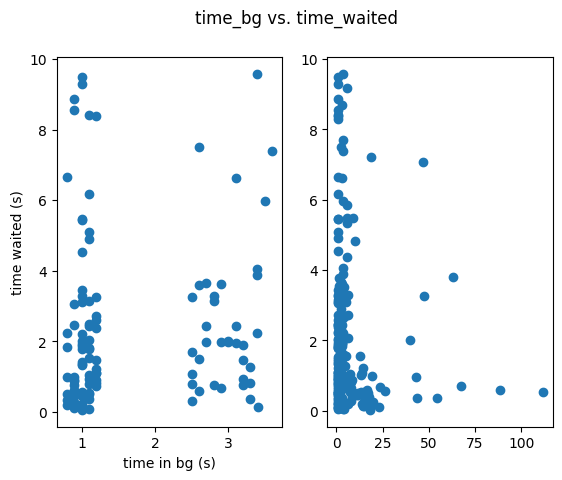

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('time_bg vs. time_waited')
ax1.scatter(good_trials.bg_length, good_trials.time_waited)
ax1.set_xlabel('time in bg (s)')
ax1.set_ylabel('time waited (s)')
ax2.scatter(all_trials.bg_length, all_trials.time_waited)
ax1.set_xlabel('time in bg (s)')
ax1.set_ylabel('time waited (s)')
fig.savefig(f'bg_vs_wait')

## block analysis

In [30]:
block_bg_avg = []
for i in total_blcok_list:
    block = session.loc[session['block_num'] == i]
    bg_avg = float(block.loc[(block['key'] == 'block') & (block['value'] == 1), 'time_bg'].iloc[0])
    block_bg_avg.append(bg_avg)
block_bg_avg

[3.021666666666667, 1.0098360655737706, 3.01875, 1.034920634920635]

In [31]:
block_num_good_trials = []
for i in total_blcok_list:
    block = good_trials.loc[good_trials['block_num'] == i]
    block_num_good_trials.append(len(block))
block_num_good_trials

[3, 28, 34, 44]

In [32]:
block_times_waited = []
for i in total_blcok_list:
    block = all_trials.loc[all_trials['block_num'] == i]
    time_waited = block.time_waited.mean()
    block_times_waited.append(time_waited)
block_times_waited

[1.4087582210014606,
 1.1219351252571481,
 2.5266898473103843,
 3.4815771190487608]

In [33]:
block_times_waited_good_trials = []
for i in total_blcok_list:
    block = good_trials.loc[good_trials['block_num'] == i]
    time_waited = block.time_waited.mean()
    block_times_waited_good_trials.append(time_waited)
block_times_waited_good_trials

[3.9901891549428306, 0.8507846679006305, 2.513611400828642, 3.3531729795716028]

In [34]:
block_reward_avg = []
for i in total_blcok_list:
    block = all_trials.loc[all_trials['block_num'] == i]
    reward_avg = block.reward_size.mean()
    block_reward_avg.append(reward_avg)
block_reward_avg

[1.8768442718785208, 1.8662939511700523, 3.445484835100413, 4.132482606635162]

In [35]:
block_reward_avg_good = []
for i in total_blcok_list:
    block = good_trials.loc[good_trials['block_num'] == i]
    reward_avg = block.reward_size.mean()
    block_reward_avg_good.append(reward_avg)
block_reward_avg_good

[4.554001505536438, 1.4967412167815943, 3.3840431828273516, 4.025971988482486]

## meta analysis

In [37]:
total_miss_trials = all_trials.miss_trial.values.sum()
total_good_trials = len(good_trials)

## debug

In [38]:
trial_3 = session.loc[session['session_trial_num'] == 3]

In [39]:
trial_3

,session_time,block_num,session_trial_num,block_trial_num,state,time_bg,reward_size,value,key
297,1.677791e+09,0,3,3,trial_ends,3.021666666666667,NaN,1,trial
298,1.677791e+09,0,3,3,in_background,3.021666666666667,NaN,1,background
299,1.677791e+09,0,3,3,in_background,3.021666666666667,NaN,1,lick
300,1.677791e+09,0,3,3,in_background,3.021666666666667,NaN,1,background
301,1.677791e+09,0,3,3,in_background,3.021666666666667,NaN,0,lick
...,...,...,...,...,...,...,...,...,...
479,1.677791e+09,0,3,3,in_consumption,3.021666666666667,6.973447,1,reward
480,1.677791e+09,0,3,3,in_consumption,3.021666666666667,NaN,0,lick
481,1.677791e+09,0,3,3,in_consumption,3.021666666666667,NaN,1,lick
482,1.677791e+09,0,3,3,in_consumption,3.021666666666667,NaN,0,lick


In [40]:
trial_8 = session.loc[session['session_trial_num'] == 8]

In [41]:
trial_8

,session_time,block_num,session_trial_num,block_trial_num,state,time_bg,reward_size,value,key
1315,1.677791e+09,0,8,8,trial_ends,3.021666666666667,NaN,1,trial
1316,1.677791e+09,0,8,8,in_background,3.021666666666667,NaN,1,background
1317,1.677791e+09,0,8,8,in_wait,3.021666666666667,NaN,1,wait
1318,1.677791e+09,0,8,8,in_wait,3.021666666666667,NaN,1,visual
1319,1.677791e+09,0,8,8,trial_ends,3.021666666666667,NaN,0,trial
